In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import csv
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [81]:
examples = []
labels = []


participant_folders = glob.glob("data/Participant_*")

for folder in participant_folders:
    participant = os.path.basename(folder)  # e.g. "Participant_1"

    
    results_files = glob.glob(os.path.join(folder, f"{participant}_results.csv"))
    if not results_files:
        print(f" No results file found in {participant}")
        continue

    data_path_lst = pd.read_csv(results_files[0])

    
    data_files = glob.glob(os.path.join(folder, "*.csv"))
    data_files = [f for f in data_files if not f.endswith("_results.csv")]

    for fname in data_files:
        base = os.path.basename(fname).replace(".csv", "")

        # ex: "trialA_pap_A_01.csv"
        parts = base.split("_")
        if len(parts) == 4:
            _, Condition, Subcondition, Trial = parts

            
            if "pap" in Condition:
                Condition = Condition.replace("pap", "PAP")
            if "camera" in Condition:
                Condition = Condition.replace("camera", "Camera")

            
            row = data_path_lst[
                (data_path_lst["Condition"] == Condition)
                & (data_path_lst["Subcondition"] == Subcondition)
                & (data_path_lst["Trial"] == Trial)
            ]

            if row.empty:
                print(f"no matching metadata: {participant}/{base}")
            

            else:
            
                df = pd.read_csv(fname)
                if "Device 0 - Follower 0" in df.columns and "Device 0 - Follower 1" in df.columns:
                    example = df[["Device 0 - Follower 0", "Device 0 - Follower 1"]].copy()
                    label = row[["Sensor1 Mean", "Sensor2 Mean"]].values.flatten().tolist()
                    examples.append(example.fillna(0))
                    labels.append(label)

print(f"Total examples collected before preprocessing: {len(examples)}")
print(f"Total labels collected before preprocessing: {len(labels)}")



# delete ['x','x']
valid_examples = []
valid_labels = []

for e, l in zip(examples, labels):
    if any(str(x).lower() == 'x' for x in l):
        continue  
    valid_examples.append(e)
    valid_labels.append(l)

print(f"Total examples collected after preprocessing: {len(valid_examples)}")
print(f"Total labels collected after preprocessing: {len(valid_labels)}")

no matching metadata: Participant_8/Participant_8_results_old
no matching metadata: Participant_6/3_training_NOhaptics_2
 No results file found in Participant_5
no matching metadata: Participant_22/10_camera_HAPTICS_ 1
no matching metadata: Participant_22/10_camera_HAPTICS_ 3
no matching metadata: Participant_22/10_camera_HAPTICS_ 2
no matching metadata: Participant_22/10_camera_HAPTICS_ 5
no matching metadata: Participant_22/10_camera_HAPTICS_ 4
no matching metadata: Participant_13/9_camera_NOhaptics_1
no matching metadata: Participant_13/9_camera_NOhaptics_2
no matching metadata: Participant_13/9_camera_NOhaptics_3
no matching metadata: Participant_13/9_camera_NOhaptics_4
no matching metadata: Participant_13/9_camera_NOhaptics_5
no matching metadata: Participant_13/10_camera_HAPTICS_4
no matching metadata: Participant_13/10_camera_HAPTICS_5
no matching metadata: Participant_13/10_camera_HAPTICS_1
no matching metadata: Participant_13/10_camera_HAPTICS_2
no matching metadata: Participa

In [82]:
# train+temp / test  : 85/15 
ex_train, ex_temp, y_train, y_temp = train_test_split(
    valid_examples, valid_labels, test_size=0.15, random_state=42
)
# train / dev  : 0.85 * 0.176 = 0.15 : 70/15/15
ex_train, ex_dev, y_train, y_dev = train_test_split(
    ex_train, y_train, test_size=0.176, random_state=42
)

print(f"Train: {len(ex_train)}, Dev: {len(ex_dev)}, Test: {len(ex_temp)}")


Train: 426, Dev: 92, Test: 92


In [83]:
def normalize_examples(example_list, scaler=None):
    scaled_tensors = []
    if scaler is None:
        scaler = StandardScaler()
        for e in example_list:
            scaled = scaler.fit_transform(e.values.astype(float))
            scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
        return scaled_tensors, scaler
    else:
        for e in example_list:
            scaled = scaler.transform(e.values.astype(float))
            scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
        return scaled_tensors

def pad_tensor_list(tensor_list):
    seq_lengths = torch.tensor([x.size(0) for x in tensor_list])
    padded = pad_sequence(tensor_list, batch_first=True, padding_value=0.0)
    return padded, seq_lengths

In [84]:
# example normalization
train_examples, ex_scaler = normalize_examples(ex_train)
dev_examples = normalize_examples(ex_dev, ex_scaler)
test_examples = normalize_examples(ex_temp, ex_scaler)

# label normalization (train 기준으로 fit)
scaler_y = StandardScaler()
y_train_arr = np.array(y_train, dtype=float)
y_dev_arr = np.array(y_dev, dtype=float)
y_test_arr = np.array(y_temp, dtype=float)

scaler_y.fit(y_train_arr)
y_train_scaled = torch.tensor(scaler_y.transform(y_train_arr), dtype=torch.float32)
y_dev_scaled = torch.tensor(scaler_y.transform(y_dev_arr), dtype=torch.float32)
y_test_scaled = torch.tensor(scaler_y.transform(y_test_arr), dtype=torch.float32)

padded_train, len_train = pad_tensor_list(train_examples)
padded_dev, len_dev = pad_tensor_list(dev_examples)
padded_test, len_test = pad_tensor_list(test_examples)

train_dataset = TensorDataset(padded_train, y_train_scaled, len_train)
dev_dataset   = TensorDataset(padded_dev, y_dev_scaled, len_dev)
test_dataset  = TensorDataset(padded_test, y_test_scaled, len_test)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataset & Loader Shapes Summary")
print("----------------------------------")
print(f"Train set ->  Examples: {len(train_dataset)},  Labels: {y_train_scaled.shape},  "
      f"Batches: {len(train_loader)} (batch_size={batch_size})")
print(f"Dev set   ->  Examples: {len(dev_dataset)},   Labels: {y_dev_scaled.shape},  "
      f"Batches: {len(dev_loader)} (batch_size={batch_size})")
print(f"Test set  ->  Examples: {len(test_dataset)},  Labels: {y_test_scaled.shape},  "
      f"Batches: {len(test_loader)} (batch_size={batch_size})")
print("----------------------------------")
print(f"Train tensor shape: {padded_train.shape}")
print(f"Dev tensor shape:   {padded_dev.shape}")
print(f"Test tensor shape:  {padded_test.shape}")



Dataset & Loader Shapes Summary
----------------------------------
Train set ->  Examples: 426,  Labels: torch.Size([426, 2]),  Batches: 54 (batch_size=8)
Dev set   ->  Examples: 92,   Labels: torch.Size([92, 2]),  Batches: 12 (batch_size=8)
Test set  ->  Examples: 92,  Labels: torch.Size([92, 2]),  Batches: 12 (batch_size=8)
----------------------------------
Train tensor shape: torch.Size([426, 4624, 2])
Dev tensor shape:   torch.Size([92, 2481, 2])
Test tensor shape:  torch.Size([92, 2631, 2])


In [85]:
if torch.backends.mps.is_available():      # M1/M2 GPU
    device = torch.device("mps")
elif torch.cuda.is_available():            # NVIDIA GPU
    device = torch.device("cuda")
else:                                      # CPU fallback
    device = torch.device("cpu")

print(f" Using device: {device}")

 Using device: mps


In [94]:
class PressureRNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_out, (h_n, c_n) = self.lstm(packed)
        
        
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        
        idx = (lengths - 1).view(-1, 1).expand(len(lengths), out.size(2)).unsqueeze(1).to(out.device)
        last_out = out.gather(1, idx).squeeze(1)

        
        
        normed = self.norm(last_out)
        out = self.fc(normed)
        
        return out


In [97]:
model = PressureRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5

Epoch [ 1/5] | Train Loss: 1.019655 | Dev Loss: 0.986089
💾 Saved new best model → best_pressureRNN_2025-11-07_12-49_epoch1_loss0.9861.pth


💾 Saved new best model → best_pressureRNN_2025-11-07_12-49_epoch2_loss0.9824.pth


💾 Saved new best model → best_pressureRNN_2025-11-07_12-49_epoch3_loss0.9769.pth


Epoch [ 5/5] | Train Loss: 1.007214 | Dev Loss: 1.024324
Training finished.
Final model saved to: ./results/weights/final_pressureRNN_2025-11-07_12-49_epoch5_loss1.0243.pth


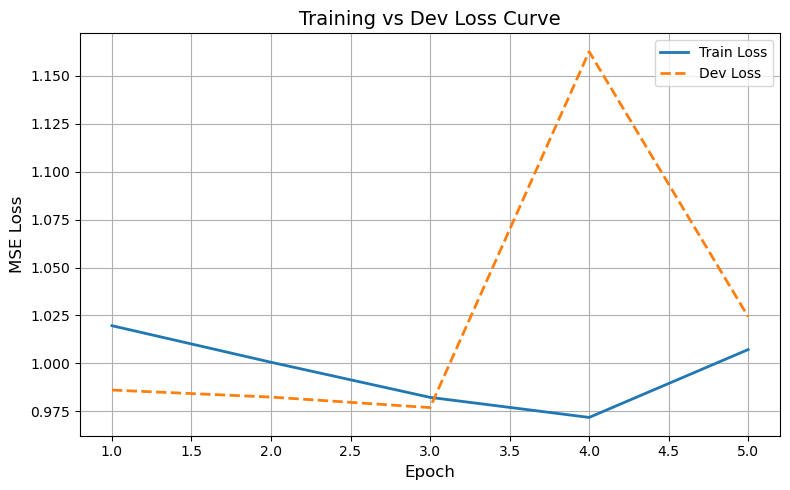

In [99]:

def train_model(model, train_loader, dev_loader, criterion, optimizer,
                device, n_epochs=50, log_interval=5, clip_norm=1.0,
                save_dir="./results/weights"):

    # --- Save directory ---
    os.makedirs(save_dir, exist_ok=True)

    train_losses = []
    dev_losses = []
    best_dev_loss = float('inf')

    # 현재 시간 태그 (ex: 2025-11-07_14-25)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0

        # --- Training ---
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
        for batch_x, batch_y, batch_len in progress:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x, batch_len)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
            optimizer.step()

            total_train_loss += loss.item() * batch_x.size(0)
            progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        total_dev_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y, batch_len in dev_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                dev_outputs = model(batch_x, batch_len)
                dev_loss = criterion(dev_outputs, batch_y)
                total_dev_loss += dev_loss.item() * batch_x.size(0)
        avg_dev_loss = total_dev_loss / len(dev_loader.dataset)
        dev_losses.append(avg_dev_loss)

        # --- Logging ---
        if (epoch + 1) % log_interval == 0 or epoch == 0:
            tqdm.write(f"Epoch [{epoch+1:>2}/{n_epochs}] | "
                       f"Train Loss: {avg_train_loss:.6f} | Dev Loss: {avg_dev_loss:.6f}")

        # --- Save best model ---
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            best_name = f"best_pressureRNN_{timestamp}_epoch{epoch+1}_loss{avg_dev_loss:.4f}.pth"
            best_path = os.path.join(save_dir, best_name)
            torch.save(model.state_dict(), best_path)
            tqdm.write(f"💾 Saved new best model → {best_name}")

    # --- Save final model (only once) ---
    final_name = f"final_pressureRNN_{timestamp}_epoch{n_epochs}_loss{avg_dev_loss:.4f}.pth"
    final_path = os.path.join(save_dir, final_name)
    torch.save(model.state_dict(), final_path)
    print(f"Training finished.\nFinal model saved to: {final_path}")

    return train_losses, dev_losses


def plot_now(n_epochs, train_losses, dev_losses):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss', linewidth=2)
    plt.plot(range(1, n_epochs+1), dev_losses, label='Dev Loss', linewidth=2, linestyle='--')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title('Training vs Dev Loss Curve', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_losses, dev_losses = train_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    log_interval=5
)

plot_now(n_epochs, train_losses, dev_losses)


In [100]:

log_path = os.path.join("results", "experiment_logs.csv")

def log_experiment(params):
    file_exists = os.path.exists(log_path)
    with open(log_path, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=params.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(params)

def save_loss_plot(train_losses, dev_losses, title, filename):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(dev_losses, label="Dev Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f" Saved loss plot: {filename}")

def summarize_model(model: torch.nn.Module):
    lines = []
    for name, layer in model.named_children():
        layer_str = str(layer).replace("\n", "")
        lines.append(f"{name}: {layer_str}")
    return " → ".join(lines)


timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

params = {
    "timestamp": timestamp,
    "architecture": summarize_model(model),
    "hidden_dim": model.lstm.hidden_size,
    "num_layers": model.lstm.num_layers,
    "dropout": 0.3,
    "learning_rate": 1e-3,
    "batch_size": 8,
    "n_epochs": 50,
    "train_size": len(train_loader.dataset),
    "dev_size": len(dev_loader.dataset),
    "final_train_loss": round(train_losses[-1], 6),
    "final_dev_loss": round(dev_losses[-1], 6),
    "best_dev_loss": round(min(dev_losses), 6),
    "best_epoch": int(dev_losses.index(min(dev_losses)) + 1),
    "optimizer": "Adam",
    "notes": " "
}

plot_filename = os.path.join("results", "plots", f"loss_curve_{timestamp}.png")


save_loss_plot(
    train_losses, 
    dev_losses, 
    title=f"Training vs Dev Loss ({timestamp})",
    filename=plot_filename
)

log_experiment(params)
print(f"Experiment logged to {log_path}")


 Saved loss plot: results/plots/loss_curve_2025-11-07_14-45-47.png
Experiment logged to results/experiment_logs.csv


In [101]:
df = pd.read_csv("/Users/jeongjuhyeon/Desktop/Python/CS230-Project/results/experiment_logs.csv")
df

,timestamp,architecture,hidden_dim,num_layers,dropout,learning_rate,batch_size,n_epochs,train_size,dev_size,final_train_loss,final_dev_loss,best_dev_loss,best_epoch,optimizer,notes
0,2025-11-07_12-08-20,"lstm: LSTM(2, 64, batch_first=True, dropout=0....",64,1,0.3,0.001,8,50,426,92,0.702152,1.341566,0.998132,2,Adam,
1,2025-11-07_14-45-47,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,426,92,1.007214,1.024324,0.976938,3,Adam,


In [102]:
def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch_x, batch_y, batch_len in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x, batch_len)
            preds.append(outputs.cpu().numpy())
            trues.append(batch_y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    mse = np.mean((preds - trues) ** 2)
    rmse = np.sqrt(mse)

    print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    return preds, trues

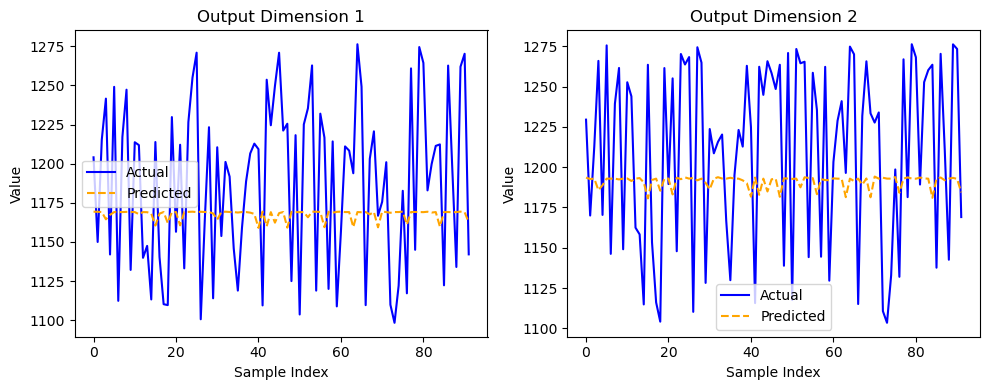

In [104]:
def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch_x, batch_y, batch_len in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x, batch_len)
            preds.append(outputs.cpu().numpy())
            trues.append(batch_y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return preds, trues


# -------------------------------
# 2️⃣ 예측 수행
# -------------------------------
preds, trues = evaluate_and_plot(model, test_loader, device)

# -------------------------------
# 3️⃣ inverse normalization (StandardScaler 사용 시)
# -------------------------------
# 학습할 때 사용했던 scaler를 그대로 사용해야 함
# 예: scaler_y = StandardScaler().fit(train_y)
preds_original = scaler_y.inverse_transform(preds)
trues_original = scaler_y.inverse_transform(trues)

# -------------------------------
# 4️⃣ Plot
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, ax in enumerate(axes):
    ax.plot(trues_original[:, i], label="Actual", color='blue')
    ax.plot(preds_original[:, i], label="Predicted", color='orange', linestyle='--')
    ax.set_title(f"Output Dimension {i+1}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()